In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pylab 
from scipy.optimize import curve_fit
from numba import njit
from scipy.misc import derivative

np.random.seed(17)

In [3]:
def plot_f(x, funcs):
    
    if not isinstance(funcs, list):
        funcs = [funcs]

    for func in funcs:
        pylab.plot(x, func(x), label=func.__name__)
    pylab.legend(loc='upper left')
    pylab.grid(True)
    pylab.show()


In [4]:
def get_act(func, popt):
    def f(x):
        return func(x, *popt)
        
    return f

In [5]:
def softplus(x):
    return np.log(1+np.exp(x))

def relu(x):
    return np.clip(x, a_min=0, a_max=None)

def relu6(x):
    return np.clip(x, a_min=0, a_max=6)

def leakyrelu(x):
    res = np.array(x)
    neg_x_idx = x < 0
    res[neg_x_idx] = 0.01*x[neg_x_idx]
    return res

def get_leaky_relu(alpha):
    def LR(x):
        res = np.array(x)
        neg_x_idx = x < 0
        res[neg_x_idx] = alpha*x[neg_x_idx]
        return res
    LR.alpha  = alpha
    return LR

def elu(x, alpha=1.0):
    res = np.array(x)
    neg_x_idx = x <= 0
    x = x[neg_x_idx]
    res[neg_x_idx] = alpha*(np.exp(x)-1)
    return res

def celu(x, alpha=1.0):
    res = np.array(x)
    neg_x_idx = x < 0
    x = x[neg_x_idx]
    res[neg_x_idx] = alpha*(np.exp(x/alpha)-1)
    return res

def selu(x, alpha=1.6732632423543772848170429916717, scale=1.0507009873554804934193349852946):
    res = np.array(x)
    neg_x_idx = x < 0
    x = x[neg_x_idx]
    res[neg_x_idx] = alpha*(np.exp(x)-1)
    return scale*res

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def swish(x):
    return x * (1.0 / (1.0 + np.exp(-x)))

In [6]:
@njit
def ratio_func54(x, w0,w1,w2,w3,w4, w5, d1, d2, d3, d4):
    c1 = 0
    xp = (x-c1)
    xp1 = xp
    xp2 = xp1*xp
    xp3 = xp2*xp
    xp4 = xp3*xp
    xp5 = xp4*xp
    
    P = w0  + w1*xp1 + w2*xp2 + w3*xp3 + w4*xp4 + w5*xp5
    Q = 1.0 + d1*xp1 + d2*xp2 + d3*xp3 + d4*xp4
    return P/Q

@njit
def ratio_func_abs54(x, w0,w1,w2,w3,w4, w5, d1, d2, d3, d4):
    c1 = 0
    xp = (x-c1)
    xp1 = xp
    xp2 = xp1*xp
    xp3 = xp2*xp
    xp4 = xp3*xp
    xp5 = xp4*xp
    
    P = w0  + w1*xp1 + w2*xp2 + w3*xp3 + w4*xp4 + w5*xp5
    Q = 1.0 + np.abs(d1)* np.abs(xp1) +  np.abs(d2)* np.abs(xp2) +  np.abs(d3)* np.abs(xp3) +  np.abs(d4)* np.abs(xp4)
    return P/Q

In [7]:
def fit_func(func, ref_func, x, p0=None, maxfev=10000000, bounds=None):
    y = ref_func(x)
    popt, _ = curve_fit(func, x, y,  p0=p0, maxfev=maxfev,  bounds=bounds)
    #print(popt)
    return popt, get_act(func, popt)

In [17]:
lr000 = get_leaky_relu(0.0)
lr001 = get_leaky_relu(0.01)
lr025 = get_leaky_relu(0.25)
lr030 = get_leaky_relu(0.30)
lr020 = get_leaky_relu(0.20)
lrm050 = get_leaky_relu(-0.50)

In [19]:
x = np.arange(-3,3,0.000001)

result = []
for lrf in [lr000]:
    popt, act_f = fit_func(ratio_func_abs54, lrf, x, bounds=(-np.inf, np.inf))
    print(lrf.alpha, popt.tolist())
    result.append([popt, act_f])
    plot_f(np.arange(-5,5,0.00001), [act_f, lrf])

AttributeError: 'function' object has no attribute 'alpha'

relu6 [0.08470411911913851, 7.2703258907789134, 35.432966095955315, 27.292038507781328, 5.915954747353017, 0.367177096063688, -76.1487917509066, 15.092549664549832, 4.6056485484840056e-08, 1.7520767761450022]


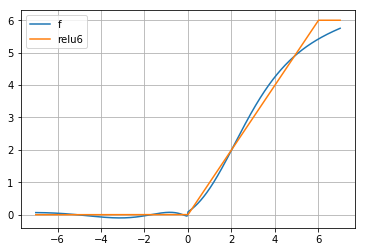

In [22]:
x = np.arange(-10,10,0.000001)


popt, act_f = fit_func(ratio_func_abs54, relu6, x, bounds=(-np.inf, np.inf))
print('relu6', popt.tolist())
plot_f(np.arange(-7,7,0.00001), [act_f, relu6])

In [14]:
popt_sigmoid = [1/2, 1/4, 1/18, 1/144, 1/2016, 1/60480, 0, 1/9, 0, 1/1000]
popt_tanh = [1/2, 1/4, 1/18, 1/144, 1/2016, 1/60480, 0, 1/9, 0, 1/1000]
popt_swish = [1/2, 1/4, 1/18, 1/144, 1/2016, 1/60480, 0, 1/9, 0, 1/1000]
popt_lrelu0_01 = [0.02979246288832245, 0.6183773789612337, 2.3233520651936534, 3.0520265972657823, 1.4854800152744463, 0.251037168372827, -1.1420122633346115, 4.393228341365807, 0.8715444974667658, 0.34720651643419215]
popt_lrelu0_20 = [0.025577756009581332, 0.6618281545012629, 1.5818297539580468, 2.944787587381909, 0.9528779431354413, 0.23319680694163697, -0.5096260509947604, 4.183768902183391, 0.3783209020348012, 0.3240731442906416]
popt_lrelu0_25 = [0.02423485464722387, 0.6770971779085044, 1.4385836314706064, 2.9549799006291724, 0.8567972159918334, 0.2322961171003388, -0.41014745814143555, 4.1469196374300115, 0.3029254642283438, 0.32002849530519256]
popt_lrelu0_30 = [0.022823661027641513, 0.6935843817924783, 1.308474321805162, 2.976815988084191, 0.7716529650279255, 0.23252265245280854, -0.3284954321510746, 4.115579017543179, 0.2415560267417864, 0.31659365394646605]
popt_lrelu0_50_neg =[0.026504409606513814, 0.8077291240826262, 13.566116392373088, 7.002178997009714, 11.614777812309141, 0.6872037476855452, -13.706489934094302, 6.077817327962073, 12.325352286416361, -0.540068802253311]

In [15]:
popt = [0.022823661027641513, 0.6935843817924783, 1.308474321805162, 2.976815988084191, 0.7716529650279255, 0.23252265245280854, -0.3284954321510746, 4.115579017543179, 0.2415560267417864, 0.31659365394646605]
act_f = get_act(ratio_func_abs54, popt_sigmoid)

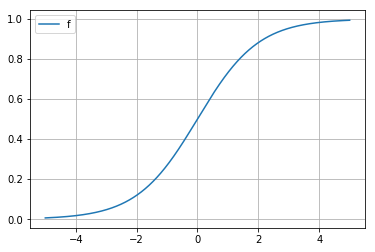

In [16]:
plot_f(np.arange(-5,5,0.00001), [act_f])